# Standard Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Constants

In [24]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

catechins = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate']
chemicals = ['Catechin', 'Epicatechin', 'Gallocatechin', 'Epigallocatechin',
       'Catechin Gallate', 'Epicatechin Gallate', 'Gallocatechin Gallate',
       'Epigallocatechin Gallate', 'Caffeine']
sensory_evaluations = ['Taste','Appearance','Aroma','Liqour color','Infused leaf']

# Import data

In [25]:
# Chemical and Instrumental Assessment of Green Tea Sensory Preference - Y.R. Liang, Q. Ye, J. Jin, H. Liang, J.L. Lu, Y.Y. Du & J.J. Dong
# https://doi.org/10.1080/10942910701299430
# Notes: downloaded CSVs

df_10942910701299430 = pd.read_csv('../data/10942910701299430/chemical_composition.csv', header=1)
df_10942910701299430 = pd.concat([df_10942910701299430, pd.read_csv('../data/10942910701299430/sensory_evaluation.csv')], axis=1)

# Phytochemical Composition and Antioxidant Capacity of 30 Chinese Teas - by Guo-Yi Tang, Cai-Ning Zhao, Xiao-Yu Xu, Ren-You Gan, Shi-Yu Cao, Qing Liu, AoShang, Qian-Qian Mao & Hua-Bin Li
# https://doi.org/10.3390/antiox8060180
# Notes: Manually scraped data

df_antiox8060180 = pd.read_csv('../data/antiox8060180/chemical_composition.csv')

# Catechin and caffeine content of tea (Camellia sinensis L.) leaf significantly differ with seasonal variation... - Himangshu Deka, Tupu Barman, Jintu Dutta, Arundhuti Devi, Pradip Tamuly, Ranjit Kumar Paul & Tanmoy Karak 
# https://doi.org/10.1016/j.jfca.2020.103684
# https://krishi.icar.gov.in/jspui/bitstream/123456789/68751/2/S0889157520313892-main.pdf - Free access

# df_j.jfca.2020.103684_chemical_composition = pd.read_csv('dava/j.jfca.2020.103684/chemical_composition.csv')

# Comparative analysis of tea catechins and theaflavins by high-performance liquid chromatography and capillary electrophoresis - Bee-Lan Lee & Choon-Nam Ong
# https://doi.org/10.1016/S0021-9673(00)00215-6
# Notes: Manually scraped data

df_S0021967300002156 = pd.read_csv('../data/S0021967300002156/chemical_composition.csv')

# Survey of Catechins, Gallic Acid, and Methylxanthines in Green, Oolong, Pu-erh, and Black Teas - Jen-Kun Lin, Chih-Li Lin, Yu-Chih Liang, Shoei-Yn Lin-Shiau & I-Ming Juan
# https://doi.org/10.1021/jf980223x
# Notes: Manually scraped data

df_jf980223x = pd.read_csv('../data/jf980223x/chemical_composition.csv')

# Analysis of some selected catechins and caffeine in green tea by high performance liquid chromatography
# https://doi.org/10.1016/j.foodchem.2012.03.039
# Notes: Manually scraped data

df_jfoodchem201203039 = pd.read_csv('../data/jfoodchem201203039/chemical_composition.csv', on_bad_lines='skip')

# Catechin content of 18 teas and a green tea extract supplement correlates with the antioxidant capacity 
# https://doi.org/10.1207/S15327914NC4502_13
# Notes: Manually scraped data

df_15327914NC4502_13 = pd.read_csv('../data/15327914NC4502_13/chemical_composition.csv')

# Catechin contents in tea (Camellia sinensis) as affected by cultivar and environment and their relation to chlorophyll contents
# https://doi.org/10.1016/j.foodchem.2010.08.029
# Notes: Manually scraped data

df_jfoodchem201008029 = pd.read_csv('../data/jfoodchem201008029/chemical_composition.csv')

In [26]:
# List of all imported dataframes
all_dataframes = [df_10942910701299430,
                  df_antiox8060180,
                  df_S0021967300002156,
                  df_jf980223x,
                  df_jfoodchem201203039,
                  df_15327914NC4502_13]

# Combine data

To combine the data I am going to create a data pipeline that does the following:

1. Add all the pandas dataframes to a list.
2. Read that list into a function.
3. The function reads an individual dataframe from that list then resets the index, rename catechins to be like the catechin dictionary below, drop unused columns, add columns that are part of the standardized column format, and then sorts the columns to be part of the standardized column format.
4. The function will then add the dataframe to a list denoting it is processed.
5. Once the function has processed all the dataframes in the lists it will loop through the data frames in the finished list and concatenate them.
6. The function will return a combined dataframe.

## Data Frame Format

The data frames will be combined into the following format:

- `'Catechin'`
- `'Epicatechin'`
- `'Gallocatechin'`
- `'Epigallocatechin'`
- `'Catechin Gallate'`
- `'Epicatechin Gallate'`
- `'Gallocatechin Gallate'`
- `'Epigallocatechin Gallate'`
- `'Gallic Acid'`
- `'Chlorogenic Acid'`
- `'Caffeine'`
- `'Taste'`
- `'Appearance'`
- `'Aroma'`
- `'Liqour color'`


In [27]:
catechin_dictionary = {
    'C': 'Catechin',
    'EC': 'Epicatechin',
    'GC': 'Gallocatechin',
    'EGC': 'Epigallocatechin',
    'CG': 'Catechin Gallate',
    'ECG': 'Epicatechin Gallate',
    'GCG': 'Gallocatechin Gallate',
    'EGCG': 'Epigallocatechin Gallate'
}

standardized_columns = [
    'Catechin',
    'Epicatechin',
    'Gallocatechin',
    'Epigallocatechin',
    'Catechin Gallate',
    'Epicatechin Gallate',
    'Gallocatechin Gallate',
    'Epigallocatechin Gallate',
    'Caffeine',
    'Taste',
    'Appearance',
    'Aroma',
    'Liqour color',
    'Infused leaf'
]

To faciliate scability I am create a sklearn pipeline and process all my data to be concatenated.
First I will define the functions that will go into my data preprocessing pipeline.

In [28]:
def reset_index(dataframe: pd.DataFrame):
    return dataframe.reset_index(drop=1)

def rename_columns(dataframe: pd.DataFrame):
    return dataframe.rename(columns=catechin_dictionary)

def drop_nonstandardized_columns(dataframe: pd.DataFrame):
    return dataframe.drop(columns=[column for column in dataframe if column not in standardized_columns])

def reformat_columns(dataframe: pd.DataFrame):
    return dataframe.reindex(columns=standardized_columns)

def remove_standard_deviation_format(dataframe: pd.DataFrame):
    for column in range(len(dataframe)):
        if (dataframe.iloc[column].dtype == 'object') or (dataframe.iloc[column].dtype == 'string'):
            dataframe.iloc[column] = dataframe.iloc[column].str.replace('± \d*.\d*', '', regex=True)
    return dataframe    

Next, the data pipeline applies all of those functions to the inputed dataset.

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ResetIndexTransformer = FunctionTransformer(reset_index)
RenameColumnsTransformer = FunctionTransformer(rename_columns)
DropNonstandardizedColumnsTransformer = FunctionTransformer(drop_nonstandardized_columns)
ReformatColumnsTransformer = FunctionTransformer(reformat_columns)
RemoveStandardDeviationFormat = FunctionTransformer(remove_standard_deviation_format)

data_combining_pipeline = make_pipeline(
    ResetIndexTransformer,
    RenameColumnsTransformer,
    DropNonstandardizedColumnsTransformer,
    ReformatColumnsTransformer,
    RemoveStandardDeviationFormat
)


Now I am creating a pipeline that transforms each dataframe then concatenates it and returns one dataframe to be used for the model.

In [30]:
def process_dataframes(dataframes: list):
    processed_dataframes = []
    for dataframe in dataframes:
        dataframe = data_combining_pipeline.fit_transform(dataframe)
        processed_dataframes.append(dataframe)
    return processed_dataframes

def concatenate_dataframes(dataframes: list):
    formated_dataframe = pd.concat(dataframes, ignore_index=True)
    return formated_dataframe

def change_dtypes(dataframe: pd.DataFrame):
    for column in dataframe.columns:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    return dataframe

In [31]:
ProcessDataframes = FunctionTransformer(process_dataframes)
ConcatenateDataframes = FunctionTransformer(concatenate_dataframes)
Change_Dtypes = FunctionTransformer(change_dtypes)

data_combining_pipeline_processor = make_pipeline(
    ProcessDataframes,
    ConcatenateDataframes,
    Change_Dtypes
)

In [32]:
df = data_combining_pipeline_processor.transform(all_dataframes)
df.head()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,8.93,7.04,8.36,18.00,3.72,4.66,21.50,21.11,31.47,23.1,7.9,23.1,8.1,15.2
1,9.87,NaN,22.55,10.92,5.33,5.29,26.62,23.42,39.24,25.8,8.1,24.9,8.3,16.4
2,6.37,4.92,21.87,10.98,5.29,5.43,24.84,23.63,41.08,23.7,7.8,23.7,7.6,15.8
3,6.78,5.91,23.08,11.47,5.76,6.43,25.34,22.14,50.97,23.7,8.3,24.0,8.6,16.6
4,5.82,5.60,24.12,13.35,5.28,5.94,27.92,25.09,53.70,24.6,8.2,26.4,8.5,16.6


# Remove Extraneous Data
It is common for this aggregated dataset to come with columns that contain no data at all, that will be removed here.

In [33]:
df = df.dropna(how='all', axis=0)

# Data Explanation

The data we will be examining and training on is purely numerical. This has many advantages in terms of cleaning and training but a few disadvantages that may not be readily appearant. The catechins and caffeine are all listed in milligrams. What is taste, appearance, aroma, and liquor color measured in? Milligrams? No, instead it is much more complicated. Thankfully this is a pretty standardized tea tasting scoring system throughout China so most of our data will reflect that, any data that does not reflect that will be modified into this scoring system. The scoring system is outlined below:


    Scoring System: They used a scoring system where the highest possible score for a tea sample was 100. This score was divided into different categories, each representing a different aspect of the tea:
        Dry Tea Appearance (10% of the total score): This is about how the tea leaves look when they are dry. The experts looked at the color, size, how tender the leaves were, and how evenly the leaves were twisted.
        Aroma (30% of the total score): This is about how the tea smells.
        Liquor Color (10% of the total score): This is about the color of the tea when it's steeped in water.
        Taste (30% of the total score): This is, of course, about how the tea tastes.
        Infused Leaf (20% of the total score): After the tea has been steeped, the experts looked at the leaves again to see their color, size, tenderness, and evenness.

    How They Tested:
        Dry Tea Appearance: They placed 200 grams of dry tea on a wooden tray (20 cm x 20 cm) and scored it based on the criteria mentioned above.
        Preparing the Tea: For testing aroma, liquor color, and taste, they steeped 3 grams of the tea in 150 milliliters of boiling water for 5 minutes.
        Tasting and Scoring: The tea was then poured into a special tasting bowl. The experts compared the aroma, color, and taste of the tea to three reference samples they had in their lab to give their scores.
        Infused Leaf: Finally, they put the steeped leaves into a porcelain tray with cold water and scored them based on color, size, tenderness, and evenness.



# Exploratory Data Analysis

This pairplot offers a high-level visualization of what is going on internally in the dataset. Next, we will examine further the intricacies of the data before cleaning it further and imputing data using a Generative Adversarial Network.

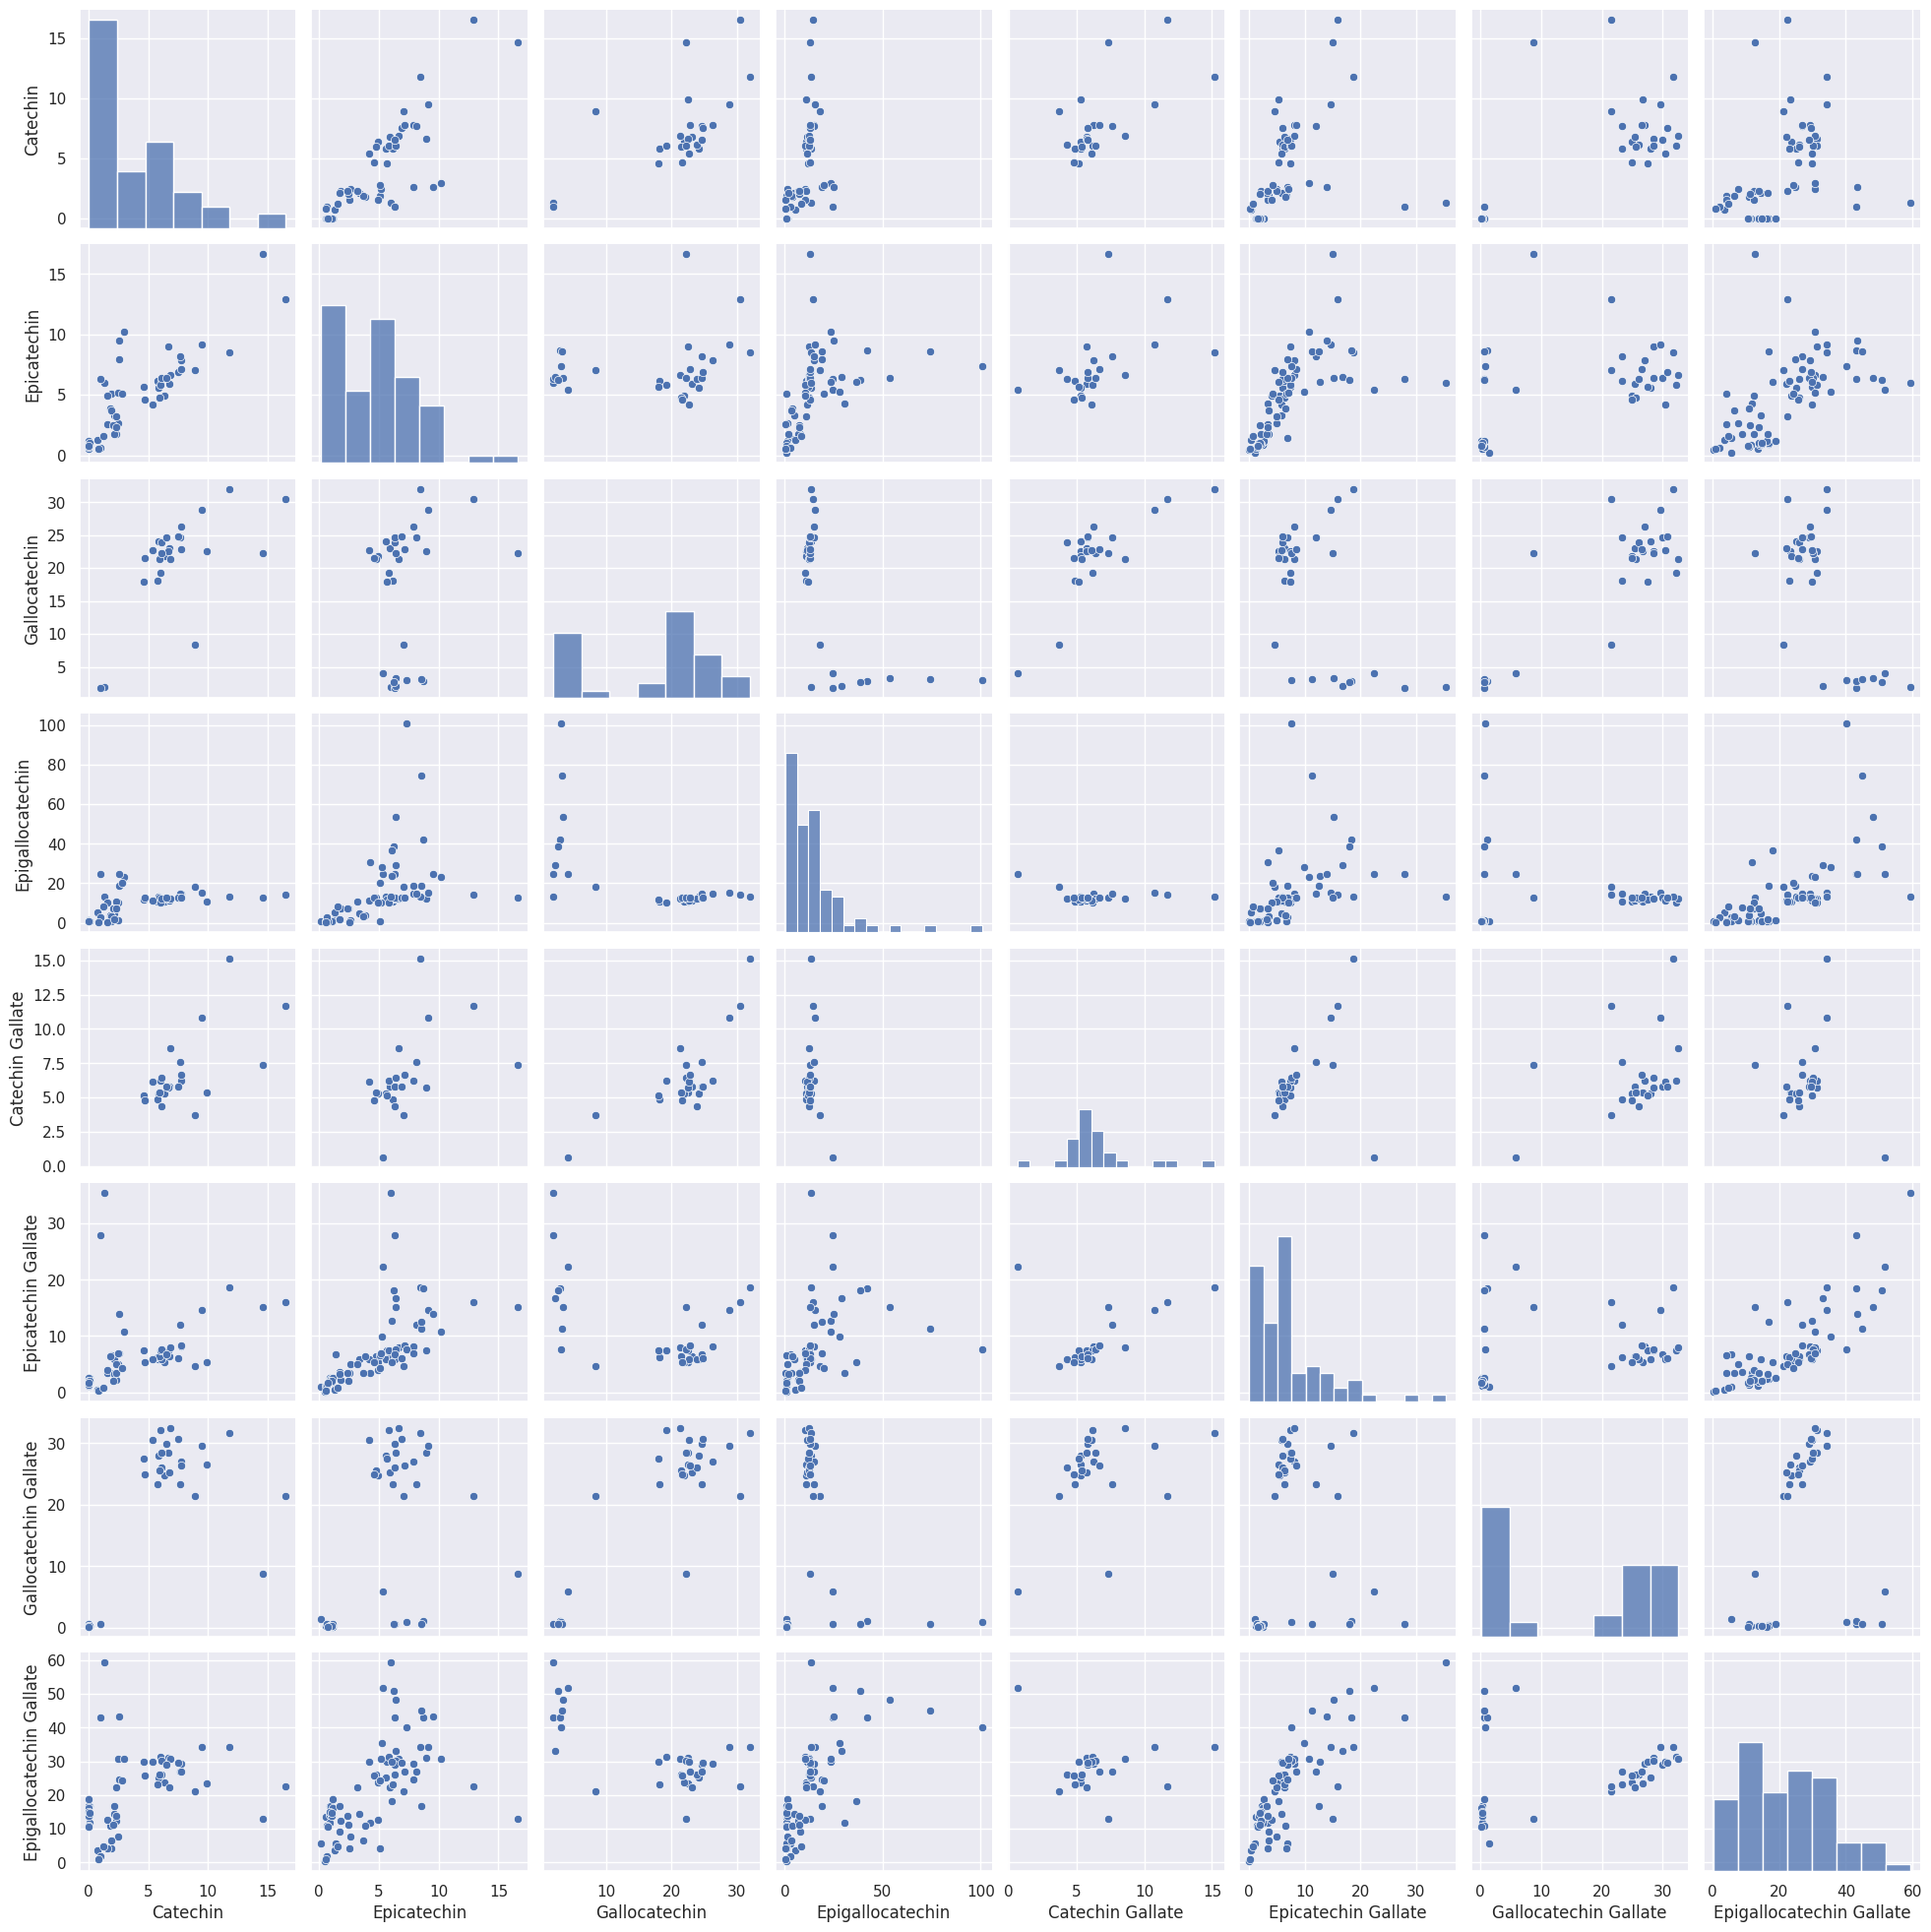

In [34]:
sns.set_theme()
sns.pairplot(df[catechins])

# Summary Statistics

The summary statistics of the agggregated data is displayed below. It is interesting to note that there are some significant outliers. One such outlier is Epigallocatechin with a max of aroun 100mg.

In [35]:
df.describe()

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
count,59.000000,74.000000,33.000000,75.000000,25.000000,74.000000,43.000000,75.000000,67.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.894441,4.767338,17.353697,13.865707,6.429800,7.408514,15.102884,22.215493,23.459701,24.275000,7.937500,24.545833,8.241667,16.433333
std,3.793119,3.266989,9.884853,16.501240,2.804528,6.508521,13.432854,13.184022,21.029612,1.506291,0.436201,1.601352,0.461488,0.856010
min,0.020000,0.190000,1.824000,0.196000,0.645000,0.070000,0.160000,0.300000,0.558000,22.200000,6.800000,22.200000,7.300000,14.800000
25%,0.986500,1.637500,4.002000,2.290000,5.280000,2.740000,0.570000,12.400000,1.925000,23.325000,7.800000,23.325000,7.950000,15.800000
50%,2.450000,5.090000,21.870000,11.300000,5.800000,5.940000,21.500000,22.300000,9.570000,23.850000,7.950000,24.400000,8.300000,16.400000
75%,6.250000,6.439750,23.900000,15.065000,6.670000,8.335000,27.270000,30.015000,44.930000,25.275000,8.125000,25.875000,8.525000,16.900000
max,16.540000,16.620000,32.020000,100.684000,15.150000,35.395000,32.540000,59.354000,58.830000,27.600000,8.800000,27.600000,8.900000,17.800000


# Training Device

As I am developing on Linux and training on Windows, this code displays if CUDA functionality is being used or not.

In [36]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Split data

For this model we will not be using a validation set because of the limited nature of the data.

In [37]:
# from torch.utils.data import DataLoader, random_split

# train_size = int(0.8 * len(df))
# test_size = len(df) - train_size
# train_df, test_df = random_split(df, [train_size, test_size])

# train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_df, batch_size=64, shuffle=True)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

# Data Imputation and Scaling

The data imputation for this aggregated dataset will be done in two parts:

1. **Chemicals Imputation**:
   - The chemicals will be imputed using sklearn's `SimpleImputer`.

2. **Min-Max Scaler**:
   - A min-max scaler will be applied so the GAN can learn features correctly.

3. **Sensory Appeals Generation**:
   - The sensory appeals will be generated by a custom `Generative Adversarial Network (GAN)`.


### Missing Chemical Imputation with an Iterative Imputer
Note this is causing some negative values that need to be fixed, possibly rows with complete missing data is causing this.

In [38]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()

train_df[chemicals] = imputer.fit_transform(train_df[chemicals])
test_df[chemicals] = imputer.transform(test_df[chemicals])

test_df


/home/tahlon/Documents/Github/DTSC-691-Capstone-Project/.venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
4,5.820000,5.600,24.120000,13.350,5.280000,5.940,27.920000,25.090,53.700000,24.6,8.2,26.4,8.5,16.6
65,2.940000,10.200,2.686531,23.200,-6.760045,10.800,-3.711100,30.700,2.230000,NaN,NaN,NaN,NaN,NaN
10,6.130000,6.310,23.900000,12.410,4.330000,5.940,26.070000,26.000,44.210000,22.5,7.8,22.8,7.5,15.6
0,8.930000,7.040,8.360000,18.000,3.720000,4.660,21.500000,21.110,31.470000,23.1,7.9,23.1,8.1,15.2
37,3.823372,6.060,10.750177,23.460,0.427069,12.660,9.357865,29.830,34.088856,NaN,NaN,NaN,NaN,NaN
63,2.450000,5.170,3.798580,10.100,-5.173460,6.970,1.614418,30.800,1.870000,NaN,NaN,NaN,NaN,NaN
29,-0.968426,7.352,3.015000,100.684,-19.168646,7.599,0.842000,40.161,29.232000,NaN,NaN,NaN,NaN,NaN
12,6.050000,5.800,19.260000,10.440,6.210000,7.430,32.120000,31.440,52.860000,25.8,8.1,25.8,8.5,17.6
71,2.580000,9.500,2.578266,24.900,-6.292206,13.900,-1.005782,43.300,1.970000,NaN,NaN,NaN,NaN,NaN
66,2.330000,1.780,2.424705,7.030,-6.028547,2.180,-3.402313,12.300,1.770000,NaN,NaN,NaN,NaN,NaN


# Feature Scaling
The data is purely numerical, therefore the data will be only normalized. 

In [39]:
# Normalization: Min-Max Scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Note: I am still not sure if I want to scale the labels.

scaled_train_df = scaler.fit_transform(train_df)
scaled_test_df = scaler.transform(test_df)

scaled_train_df = pd.DataFrame(scaled_train_df, columns=standardized_columns)
scaled_test_df = pd.DataFrame(scaled_test_df, columns=standardized_columns)

In [40]:
scaled_test_df

,Catechin,Epicatechin,Gallocatechin,Epigallocatechin,Catechin Gallate,Epicatechin Gallate,Gallocatechin Gallate,Epigallocatechin Gallate,Caffeine,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,0.365136,0.329276,0.790406,0.177718,0.750840,0.180173,0.891752,0.419785,0.914492,0.444444,0.70,0.777778,0.7500,0.600000
1,0.194575,0.609251,0.091756,0.310798,0.284294,0.315443,0.150623,0.514783,0.056582,NaN,NaN,NaN,NaN,NaN
2,0.383495,0.372489,0.783235,0.165018,0.714028,0.180173,0.848405,0.435195,0.756311,0.055556,0.50,0.111111,0.1250,0.266667
3,0.549318,0.416920,0.276689,0.240543,0.690391,0.144547,0.741328,0.352389,0.543959,0.166667,0.55,0.166667,0.5000,0.133333
4,0.246891,0.357273,0.354600,0.314310,0.562791,0.367212,0.456833,0.500051,0.587610,NaN,NaN,NaN,NaN,NaN
5,0.165556,0.303104,0.128004,0.133809,0.345773,0.208842,0.275401,0.516476,0.050581,NaN,NaN,NaN,NaN,NaN
6,-0.036891,0.435910,0.102463,1.357652,-0.196534,0.226349,0.257303,0.674992,0.506656,NaN,NaN,NaN,NaN,NaN
7,0.378757,0.341449,0.631988,0.138403,0.786877,0.221645,0.990159,0.527314,0.900491,0.666667,0.65,0.666667,0.7500,0.933333
8,0.173255,0.566646,0.088227,0.333766,0.302422,0.401726,0.214009,0.728147,0.052248,NaN,NaN,NaN,NaN,NaN
9,0.158450,0.096774,0.083221,0.092331,0.312639,0.075521,0.157858,0.203204,0.048914,NaN,NaN,NaN,NaN,NaN


# Generative Adversarial Network

The purpose of the GAN is to impute missing sensory values. A GAN is a combination of two neural networks: a generator and a discriminator. The generator will generate numbers that it thinks are the appropiate sensory evaluations based on the givens catechins and caffeine input. The discriminator will then decide if that is a realistic output or not. In the end, all missing data on sensory evaluations will be naturally imputted. Much of this was interpreted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html although specifically using GAN not DCGAN.

In [41]:
# Create a training dataset for the GAN (rows that include all sensory scores)
GAN_train_df = scaled_train_df[(scaled_train_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) # Subset of data containinag complete sensory evaluations
GAN_test_df = scaled_test_df[(scaled_test_df[sensory_evaluations] > 0).all(axis=1)].dropna(axis=0) 

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Layer
            nn.Linear(9, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 5),
            nn.Sigmoid() # This is used because output values are in the range [0, 1)
        )


    def forward(self, input):
        output = self.main(input)
        return output

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input layer
            nn.Linear(14, 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout to prevent overfitting

            # Hidden layer
            nn.Linear(16, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            # Output layer - single neuron for binary classification (real or fake)
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid to output a probability
        )


    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1) # Outputs 1D tensor of probabilities 


In [44]:
# Custom GAN Dataset
from torch.utils.data import Dataset

class GANDataset(Dataset):
    def __init__(self, dataframe):
        self.data_frame = dataframe

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data_frame.iloc[idx]
        sample = torch.tensor(sample.values, dtype=torch.float32)
        return sample

GAN_dataset = GANDataset(GAN_train_df)

In [45]:
# GAN Dataloader 
from torch.utils.data import DataLoader
dataloader = DataLoader(GAN_dataset, batch_size=32, shuffle=True)

In [46]:
# Model Creation
generator = Generator().to(device)
discriminator = Discriminator().to(device)

I would like to make all of this a reusable pytorch class

In [47]:
# Setup Adam optimizers for both G and D
import torch.optim as optim
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

generator_losses = []
discriminator_losses = []
epochs = 50

def train_GAN():
    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):
            
            # Seperate data and convert to current device
            chemical_data = data[:, :9]
            sensory_data = data[:, 9:]

            chemical_data = chemical_data.to(device)
            sensory_data = sensory_data.to(device)

            # Find current batch size
            current_batch_size = chemical_data.size(0)

            # Create labels for real and generated data
            real_label = torch.full((current_batch_size,), 1., dtype=torch.float, device=device) # Creates a tensor of labels indiciated data is real
            fake_label = torch.full((current_batch_size,), 0. , dtype=torch.float, device=device) # Creates a tensor of labels indidicated data is generated

            # Update Discriminator - Clear accumulated gradients from previous pass
            discriminator.zero_grad()

            # Train discriminator with real data w/ some notes for myself
            real_data = torch.cat((chemical_data, sensory_data), 1) # Same as pd.concat(axis=1)
            output = discriminator(real_data).view(-1) # Same as numpy.reshape(-1,1), used to calculate loss
            errD_real = criterion(output, real_label)
            errD_real.backward() # Perform backpropogation based on errD_real
            D_x = output.mean().item() # Outputs average discriminator prediction

            # Train discriminator with fake data
            fake_sensory_data = generator(chemical_data) 
            fake_data = torch.cat((chemical_data, fake_sensory_data), 1) # Create a dataset of real chemical data but generated sensory data
            output = discriminator(fake_data.detach()).view(-1) # detach is used to ensure gradients aren't computed for the generator during the discriminators backwards pass
            errD_fake = criterion(output, fake_label)
            errD_fake.backward()
            D_G_z1 = output.mean().item() # Outputs average descriminator prediction for fake data

            # Update Discriminator weights
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update Generator
            generator.zero_grad()
            output = discriminator(fake_data).view(-1)
            errG = criterion(output, real_label)
            errG.backward()
            D_G_z2 = output.mean().item()

            # Update Generate weights
            optimizerG.step()

            # Print training log
            if i % 50 == 0: # Prints every 50 batches, might change
                print(f'[{epoch}/{epochs}][{i}/{len(dataloader)}] '
                    f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                    f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
                
            # Save losses
            generator_losses.append(errG.item())
            discriminator_losses.append(errD.item())

train_GAN()

[0/50][0/1] Loss_D: 1.3791 Loss_G: 0.6976 D(x): 0.4961 D(G(z)): 0.4921 / 0.4980
[1/50][0/1] Loss_D: 1.3850 Loss_G: 0.6944 D(x): 0.5027 D(G(z)): 0.5016 / 0.4996
[2/50][0/1] Loss_D: 1.4021 Loss_G: 0.6941 D(x): 0.4962 D(G(z)): 0.5037 / 0.4996
[3/50][0/1] Loss_D: 1.3977 Loss_G: 0.6971 D(x): 0.4977 D(G(z)): 0.5033 / 0.4982
[4/50][0/1] Loss_D: 1.3948 Loss_G: 0.6943 D(x): 0.4978 D(G(z)): 0.5017 / 0.4996
[5/50][0/1] Loss_D: 1.3889 Loss_G: 0.7031 D(x): 0.5032 D(G(z)): 0.5041 / 0.4952
[6/50][0/1] Loss_D: 1.3965 Loss_G: 0.6951 D(x): 0.4976 D(G(z)): 0.5024 / 0.4992
[7/50][0/1] Loss_D: 1.3912 Loss_G: 0.6927 D(x): 0.4965 D(G(z)): 0.4987 / 0.5003
[8/50][0/1] Loss_D: 1.3812 Loss_G: 0.6966 D(x): 0.5049 D(G(z)): 0.5020 / 0.4986
[9/50][0/1] Loss_D: 1.3844 Loss_G: 0.6950 D(x): 0.4971 D(G(z)): 0.4959 / 0.4993
[10/50][0/1] Loss_D: 1.3712 Loss_G: 0.6915 D(x): 0.5028 D(G(z)): 0.4949 / 0.5010
[11/50][0/1] Loss_D: 1.3760 Loss_G: 0.6862 D(x): 0.4977 D(G(z)): 0.4922 / 0.5037
[12/50][0/1] Loss_D: 1.3698 Loss_G: 0.

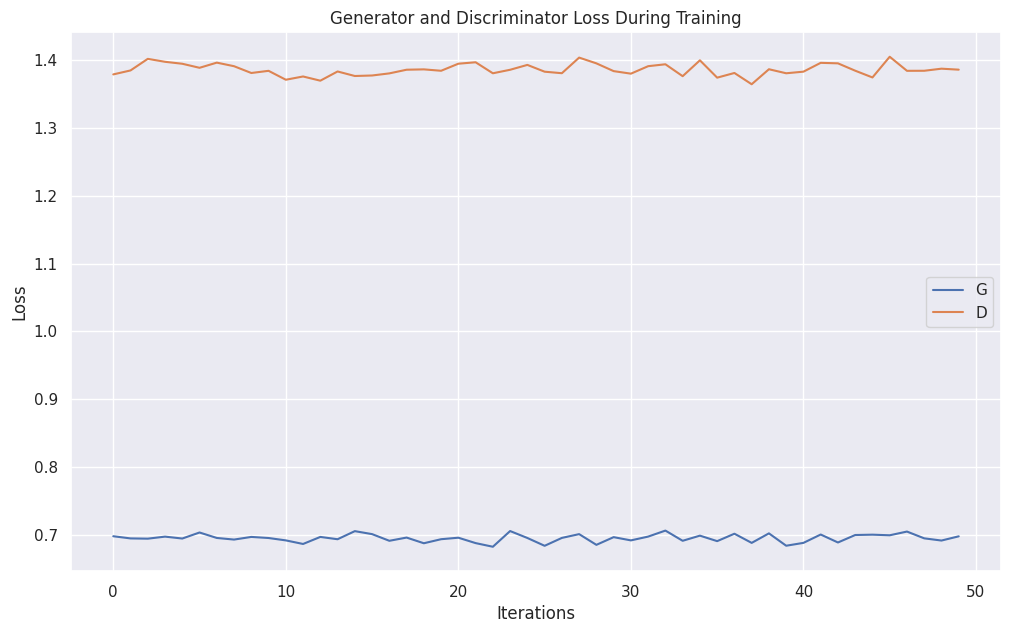

In [48]:
def plot_GAN_loss():
    plt.figure(figsize=(12,7))
    plt.title('Generator and Discriminator Loss During Training')
    plt.plot(generator_losses, label='G')
    plt.plot(discriminator_losses, label='D')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

plot_GAN_loss()

# Define rows that need to be imputed
These are the rows currently missing sensory data

In [49]:
train_data_to_impute = torch.tensor(scaled_train_df[(scaled_train_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values)
test_data_to_impute = torch.tensor(scaled_test_df[(scaled_test_df[sensory_evaluations].isna()).all(axis=1)][chemicals].values)

# Impute missing sensory data with the GAN

In [50]:
generator.eval()

with torch.no_grad():
    imputed_sensory_data_train = pd.DataFrame(generator(train_data_to_impute.float()).numpy(), columns=sensory_evaluations)
    imputed_sensory_data_test = pd.DataFrame(generator(test_data_to_impute.float()).numpy(), columns=sensory_evaluations)

In [51]:
imputed_sensory_data_train # Note, index is not right not simply concat on axis=1

,Taste,Appearance,Aroma,Liqour color,Infused leaf
0,0.444134,0.288160,0.558925,0.589501,0.679871
1,0.272122,0.170939,0.573977,0.562809,0.770975
2,0.287040,0.127644,0.638874,0.556326,0.810842
3,0.291959,0.166375,0.574236,0.544093,0.788537
4,0.233661,0.129754,0.570480,0.537833,0.771626
5,0.300260,0.153727,0.589338,0.530688,0.831986
6,0.301661,0.164379,0.567956,0.535286,0.836285
7,0.531930,0.242943,0.727198,0.719653,0.611925
8,0.287388,0.165948,0.601470,0.558796,0.764240
9,0.312197,0.153198,0.597096,0.528876,0.838064


# Concatenate imputed values to host dataframe

In [52]:
train_df = pd.concat((scaled_train_df[(scaled_train_df[sensory_evaluations].isna()).all(axis=1)][chemicals], imputed_sensory_data_train), axis=1)
test_df = pd.concat((scaled_test_df[(scaled_test_df[sensory_evaluations].isna()).all(axis=1)][chemicals], imputed_sensory_data_test), axis=1)
# This is not correct right now

# Feature Engineering

A derived feature called overall score will be produced from all sensory scores so the models only have to predict a single response.

In [53]:
# Derived Feature: Overall Sensory Score
def compute_sensory_score(df):
    df['Overall Sensory Score'] = df['Taste'] + df['Appearance'] + df['Aroma'] + df['Liqour color'] + df['Infused leaf']
    df = df.drop(columns=['Taste','Appearance','Aroma','Liqour color','Infused leaf'])
    return df

train_df = compute_sensory_score(train_df)
test_df = compute_sensory_score(test_df)


# PCA (Principal Component Analysis)

Because the high-dimensional nature of the data, PCA will be used to reduce the number of features.

In [54]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2)

train_X = pca.fit_transform(train_df.drop(columns=['Overall Sensory Score']))
test_X = pca.transform(test_df.drop(columns=['Overall Sensory Score']))

train_y = train_df[['Overall Sensory Score']]
test_y = test_df[['Overall Sensory Socre']]

ValueError: Input X contains NaN.
KernelPCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def plot_explained_variance():  
    plt.figure(figsize=(12, 7))
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Explained Variance by Each Principal Components')
    plt.show()

# DBSCAN

Pytorch does not have a built in DBSCAN class, instead we will use scikit learn's implementation. 

In [ ]:
# Model Creation
from sklearn.cluster import DBSCAN
GridSearchCV_DBSCAN = DBSCAN()

In [ ]:
# Hyperparameter Selection
from sklearn.model_selection import GridSearchCV

parameters_dbscan = {
    'eps': [_ for _ in np.arange(.5, 5.5, .5)],
    'min_samples': [_ for _ in np.arange(2, 6, 1)],
    'metric': ['euclidian' , 'sqeuclidian', 'cosine', 'cityblock', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [_ for _ in np.arange(20, 41, 1)],
    'n_jobs': [-1]
}

DBSCAN_GridSearchCV = GridSearchCV(GridSearchCV_DBSCAN, parameters_dbscan)
DBSCAN_GridSearchCV.fit(train_X, train_y)
DBSCAN_GridSearchCV.best_params_, DBSCAN_GridSearchCV.best_score_

In [ ]:
# Model Training
Model_DBSCAN = DBSCAN() # Insert model parameters from above here.

# Ensemble Method

# Multilayer Perceptron
This multilayer perceptron outputs a overall sensory score based on input chemicals.

notes: I ultimately want someone to put in a tea and see if it is generally likeable. This returns the scaled score so I need to return that scaled score into an interpretable one. Next I need to see how I would integrate this model into an interactie web app. Think about that...

In [ ]:
# Model Creation
class MLP(nn.Module):
    def __init__(self):
        super().__init__()  
        self.mean = nn.Sequential(
            # First Layer
            nn.Linear(9, 16),
            nn.ReLU(),

            # Second Layer
            nn.Linear(16, 32),
            nn.ReLU(),

            # Output Layer
            nn.Linear(32, 1)
            nn.ReLU() # Used because the output is greater than 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

GridSearchCV_MLP = MLP()

In [ ]:
# Training Loop Creation - very rough creation
def train_MLP(model, X, y):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    for epoch in range(epochs):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Hyperparameter Selection
parameters_mlp = {
    '':[]
}

# https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

MLP_GridSearchCV = GridSearchCV(GridSearchCV_MLP, parameters_mlp)
MLP_GridSearchCV.fit(train_X, train_y)
MLP_GridSearchCV.best_params_, MLP_GridSearchCV.best_score_

In [ ]:
# Model Training
Model_MLP = MLP() # Insert model parameters from above here.

# Convolutiontional Neural Network

In [ ]:
# Model Creation

In [ ]:
# Hyperparameter Selection


In [ ]:
# Model Training

# Model Visualization and Comparison

In [ ]:
def visualize_models():
    pass

# Export model

This model will be deployed in Python via a REST API with Flask. The Flask web app will then be deployed to a Linux web server using Unicorn.

In [ ]:
def save_models():
    torch.save(Model_MLP, 'mlp.pickle')